In [1]:
!pip install confluent-kafka
!pip install pyenchant

In [2]:
import pandas as pd
from confluent_kafka import Producer
from confluent_kafka import Consumer
import re
import enchant
from pyspark import SparkContext
from pyspark.streaming import StreamingContext 

english_dict = enchant.Dict("en_US")

ROMEO_AND_JULIET_TOPIC = 'RomeoAndJuliet'

In [3]:
words_df = pd.read_csv('AFINN-111.txt', sep="\t", header=None)
words_df.columns = ["Word","SentValue"]


In [4]:
def getSentValue(word):
    res = words_df[words_df['Word'] == word]
    if len(res) == 1:
        return float(res['SentValue'])
    return 0

# Consumer

In [5]:
conf = {'bootstrap.servers': "localhost:9092",
        'group.id': "foo",
        'auto.offset.reset': 'latest'}

consumer = Consumer(conf)

In [6]:
running = True
history = {}
def basic_consume_loop(consumer, topics):
    batch_number = 0
    try:
        consumer.subscribe(topics)

        while running:
            msg = consumer.poll(timeout=2.0)
            if msg is None: continue

            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    # End of partition event
                    sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                     (msg.topic(), msg.partition(), msg.offset()))
                elif msg.error():
                    raise KafkaException(msg.error())
            else:
                batch_number += 1
                words = [x.lower() for x in re.split('\W',msg.value().decode('utf-8')) if x != '' and english_dict.check(x.lower()) and x.isnumeric() is False]
                words = sc.parallelize(words)
                word_sent_values = words.map(lambda x:getSentValue(x)).collect()
                history[batch_number] = sum(word_sent_values)
                lines_range = msg.key().decode('utf-8')
                print(f'{batch_number}: Lines {lines_range} arrived successfully.')


    finally:
        # Close down consumer to commit final offsets.
        consumer.close()

def shutdown():
    running = False

In [7]:
basic_consume_loop(consumer,[ROMEO_AND_JULIET_TOPIC])

1: Lines 0:100 arrived successfully.
2: Lines 0:100 arrived successfully.
3: Lines 100:200 arrived successfully.
4: Lines 200:300 arrived successfully.
5: Lines 300:400 arrived successfully.
6: Lines 400:500 arrived successfully.
7: Lines 500:600 arrived successfully.
8: Lines 600:700 arrived successfully.
9: Lines 700:800 arrived successfully.
10: Lines 800:900 arrived successfully.
11: Lines 900:1000 arrived successfully.
12: Lines 1000:1100 arrived successfully.
13: Lines 1100:1200 arrived successfully.
14: Lines 1200:1300 arrived successfully.
15: Lines 1300:1400 arrived successfully.
16: Lines 1400:1500 arrived successfully.
17: Lines 1500:1600 arrived successfully.
18: Lines 1600:1700 arrived successfully.
19: Lines 1700:1800 arrived successfully.
20: Lines 1800:1900 arrived successfully.
21: Lines 1900:2000 arrived successfully.
22: Lines 2000:2100 arrived successfully.
23: Lines 2100:2200 arrived successfully.
24: Lines 2200:2300 arrived successfully.
25: Lines 2300:2400 arrive

KeyboardInterrupt: 

### Display a plot showing a sentiment level at each time interval N

In [8]:
df = pd.DataFrame.from_dict(history.items())
df.columns = ['Batch Number','Sum']

<AxesSubplot:xlabel='Batch Number'>

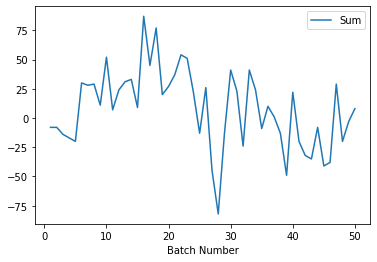

In [9]:
df.plot('Batch Number','Sum')